In [1]:
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

/home/misha/anaconda3/envs/lego/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [2]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['name'], self.data_df.iloc[idx]['sings']
        #print(image_name)
        #print(torch.tensor(label).long())
        # читаем картинку. read the image
        image = Image.open(image_name).convert('RGB')
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [6]:
# задаем преобразование изображения.

train_transform = transforms.Compose([
    transforms.Resize(64),
    #transforms.RandomResizedCrop(224),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          #std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize(64),
    #transforms.RandomResizedCrop(224),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          #std=[0.229, 0.224, 0.225]),
])

In [7]:
# читаем датасет
data_df = pd.read_csv("lab.csv")

In [8]:
data_df

,name,sings
0,data/5.5/popytnaya.jpeg,48
1,data/5.5/Odnostoronnee.png,48
2,data/5.5/DSCN3631.jpg,48
3,data/5.5/C1LMsqV5Pes.jpg,48
4,data/5.5/d6e13c00821c22b974d54df5ae241e31.jpg,48
...,...,...
499,data/5.21/zhilayazona1.jpg,67
500,data/5.21/100-3.jpg,67
501,data/5.21/890-890-0-1024x1024.jpg,67
502,data/5.21/x_yb2j9auirdivonyvs8deypagxfdr-p.jpeg,67


In [39]:
from os import listdir

print("Обучающей выборки " ,len(listdir("train")))
#print("Тестовой выборки " ,len(listdir("/content/test")))

Обучающей выборки  778


<AxesSubplot:xlabel='sings', ylabel='count'>

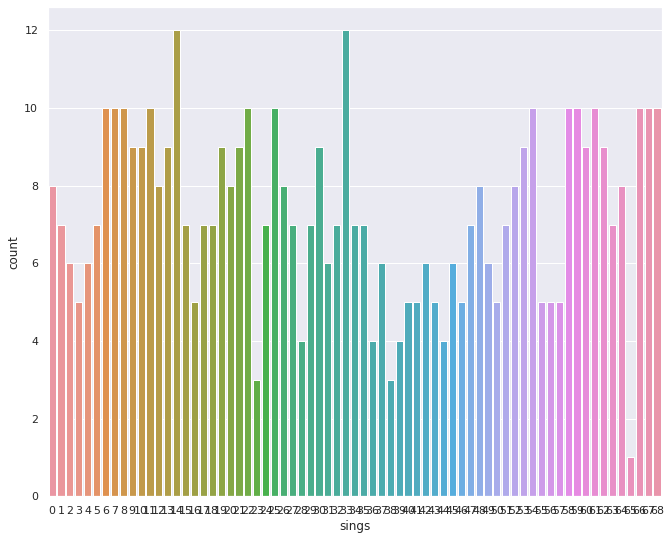

In [40]:
import seaborn as sns
import warnings

warnings.simplefilter('ignore')

sns.set(rc={'figure.figsize':(11,9)})
sns.countplot(x = "sings" , data  = data_df)

Обратим внимание, что в чтолбце существуют пропуски. Видоизменим такие данные


In [8]:
old_sing4_vl = data_df.sing4.unique()
new_sing4_vl = [x for x in range(len(old_sing4_vl))]

rename_nums = {"sing4": {old_sing4_vl[x]:x for x in new_sing4_vl}} 

data_df = data_df.replace(rename_nums)

<AxesSubplot:xlabel='sing4', ylabel='count'>

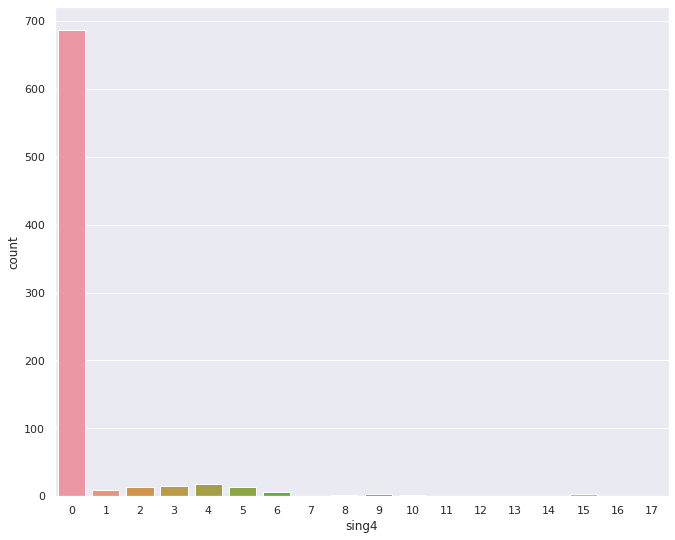

In [9]:
sns.set(rc={'figure.figsize':(11,9)})
sns.countplot(x = "sing4" , data  = data_df)

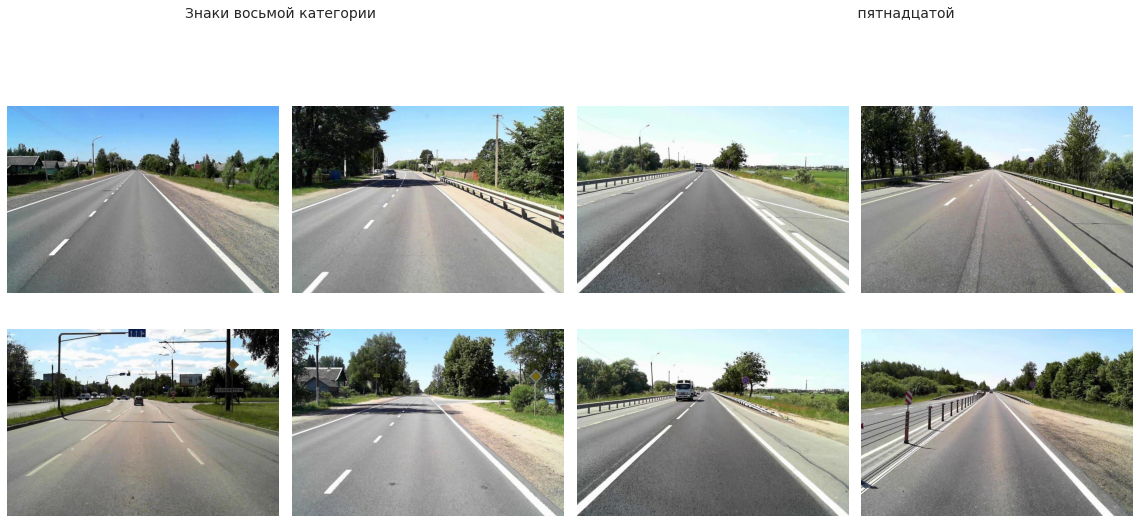

In [10]:
# посмотрим на картинки. let's look at the images

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Знаки восьмой категории {" "*105} пятнадцатой', fontsize=14)

for i, name in zip(range(4), data_df[ data_df['sing1'] == 8 ].sample(4, random_state=42)['img']):
    axs[i // 2, (i % 2)].imshow(plt.imread(f"train/{name}"))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), data_df[ data_df['sing1'] == 15 ].sample(4, random_state=42)['img']):
    axs[i // 2, (i % 2)+2].imshow(plt.imread(f"train/{name}"))
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

Обратим внимание, что знаки занимают очень малую часть изображения

In [9]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=43)

In [10]:
train_df.shape, valid_df.shape

((403, 2), (101, 2))

In [11]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [12]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=1,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=1,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

## Вспомогательные функции

In [13]:
def crossvalid(res_model=None,criterion=None,optimizer=None,dataset=None,k_fold=5):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
        
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
        train_score.at[i] = train_acc
        #val_acc = valid(res_model,criterion,optimizer,val_loader)
        #val_score.at[i] = val_acc
    
    return train_score,val_score

In [14]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [23]:
def train(res_model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()
            #print(labels)
            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))
            
            train_pred += (torch.argmax(y_pred[0]) == labels).sum()

            optimizer.step()

        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                
                val_loss += loss.item()
                val_size += pred.size(0)
                
                val_pred += (torch.argmax(pred[0]) == labels).sum()
        

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()
        #plot_history(train_loss_log, val_loss_log, 'loss')
        


        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

## Модель

In [16]:
torch.cuda.empty_cache()

In [24]:
# Подргружаем модель

model = models.resnet152(pretrained=True)
model.fc = nn.Linear(2048, 69)

model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()

In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, 
                                                                 criterion, 
                                                                optimizer, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 100)

  1%|▍                                        | 1/100 [00:46<1:16:01, 46.08s/it]

Train loss: 636.3770207163714
Val loss: 784565.4987018887
Train acc: tensor(0.7444, device='cuda:0')
Val acc: tensor(2.9703, device='cuda:0')


## Посмотрим метрики нашей итоговой модели на валидации.

In [24]:
model.eval()
valid_predicts = []

for imgs, _ in tqdm(valid_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts.append(index)

  0%|                                                     | 0/5 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 36.00 MiB (GPU 0; 11.75 GiB total capacity; 10.00 GiB already allocated; 29.25 MiB free; 10.41 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
valid_df["pred"] = valid_predicts

# Посчитаем точность модели

In [ ]:
from sklearn.metrics import recall_score

In [ ]:
valid_df['pred'].values

In [ ]:
val_accuracy = recall_score(valid_df['sing8'].values, valid_df['pred'].values, average='macro', zero_division  =0)
print(f"Validation accuracy = {val_accuracy}")